In [ ]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

In [ ]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [ ]:
import sys
import re
import os
import json
import datetime
import pytz
import numpy as np


In [ ]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
    allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)


In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [ ]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



In [ ]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
    fh.write("\n".join(foundsymbols))
foundsymbols

In [ ]:
#split into multiple corpus here


import random
random.shuffle(relevant_posts)
n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

In [ ]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
training_data=""
for post in training_posts:
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"] 
    training_data += text.replace("\n","")+"\n"

In [ ]:
%%time

import boto3
prefix='wsb-xgboost-blazingtext'
region = boto3.Session().region_name
s3=boto3.client('s3')

train_channel = prefix + '/train'

s3.put_object(Bucket=bucket,Key=train_channel,Body=training_data)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)


In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [ ]:
train_data_input = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data_input}

In [ ]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))


In [ ]:
role = sagemaker.get_execution_role()

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.10xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=session)

In [ ]:


bt_model.set_hyperparameters(mode="batch_skipgram")


In [ ]:
train_data_input = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

In [ ]:
%%time

bt_model.fit(inputs=data_channels, logs=True)

In [ ]:
text_vectorizer = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

In [ ]:
threshhold=.05

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"]
    texttokens=lt(text)
    #print(text,texttokens)
    #print("Symbol:",thesesymbols)
    payload = {"instances" : text.split(" ")}
    response = text_classifier.predict(json.dumps(payload))
    wordvector=json.loads(response)
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
        #if True:
            
                #if word in texttokens:
                    #print(word)
                #    wordvector.append(1)
                #else:
                #    wordvector.append(0)
                #locword = text.find(word)
                #distance=0
                #if locword>-1:
                #    distance=abs(text.find(symbolmap[symbol])-locword)
                #    print(symbol,word,distance)
                #wordvector.append(distance)
            #print(symbol,wordvector)
            posttime=[0,0,0,0]
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=21:
                posttime[0]=1
            elif start.hour < 5:
                posttime[0]=1
            elif start.hour < 9:
                posttime[1]=1
            elif start.hour < 16:
                posttime[2]=1
            else:
                posttime[3]=1
            if start.hour>=9:
                start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
                #print(symbol,delta,result,wordvector)
            else:
                result=0
            returnarray.append([result]+posttime+wordvector)
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray


def calculateVectors(posts):
    vector = []
    i=0
    for post in posts:
        #try:
        if True:
           response=calculateData(post)
           for row in response:
                vector.append(row)
        #except Exception as err:
        #    print("Error",err)
        #    pass
        i+=1
        if(round(i/100,0)==i/100):
            update_progress(i / len(posts))
    vector=np.array(vector).astype('float32')
    return vector

training_vector = calculateVectors(training_posts)
test_vector = calculateVectors(test_posts)
val_vector = calculateVectors(val_posts)

In [15]:
import pandas as pd
pd.DataFrame(training_vector, columns=["Output"]+["21-4","5-8","9-15","16-20"]+vocab_list)

,Output,21-4,5-8,9-15,16-20,ability,able,absolute,absolutely,accept,...,yolos,york,young,youtube,yoy,yr/yr,ytd,zero,zone,zoom
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68391,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68392,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68393,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68394,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
training_vector[0:1]

array([[0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
%%time

import struct
import io
import boto3

prefix='wsb-xgboost'
region = boto3.Session().region_name
 
def to_libsvm(f, labels, values):
     f.write(bytes('\n'.join(
         ['{} {}'.format(label, ' '.join(['{}:{}'.format(i + 1, el) for i, el in enumerate(vec)])) for label, vec in
          zip(labels, values)]), 'utf-8'))
     return f


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(partition_name, partition):
    labels = [t.tolist() for t in partition[:,0]]
    vectors = [t.tolist() for t in partition[:,1:]]
    num_partition = 5                                 # partition file into 5 parts
    partition_bound = int(len(labels)/num_partition)
    for i in range(num_partition):
        f = io.BytesIO()
        to_libsvm(f, labels[i*partition_bound:(i+1)*partition_bound], vectors[i*partition_bound:(i+1)*partition_bound])
        f.seek(0)
        key = "{}/{}/examples{}".format(prefix,partition_name,str(i))
        url = 's3n://{}/{}'.format(bucket, key)
        print('Writing to {}'.format(url))
        write_to_s3(f, bucket, key)
        print('Done writing to {}'.format(url))

def download_from_s3(partition_name, number, filename):
    key = "{}/{}/examples{}".format(prefix,partition_name, number)
    url = 's3n://{}/{}'.format(bucket, key)
    print('Reading from {}'.format(url))
    s3 = boto3.resource('s3', region_name = region)
    s3.Bucket(bucket).download_file(key, filename)
    #try:
    #    s3.Bucket(bucket).download_file(key, 'mnist.local.test')
    #except botocore.exceptions.ClientError as e:
    #    if e.response['Error']['Code'] == "404":
    #        print('The object does not exist at {}.'.format(url))
    #    else:
    #        raise        
        
def convert_data():
    partitions = [('train', training_vector), ('validation', val_vector), ('test', test_vector)]
    for partition_name, partition in partitions:
        print('{}: {} {}'.format(partition_name, partition[:,0].shape, partition[:,1:].shape))
        upload_to_s3(partition_name, partition)

CPU times: user 5.7 ms, sys: 3.98 ms, total: 9.68 ms
Wall time: 9.19 ms


In [18]:
val_vector[:,1:].shape

(8285, 2504)

In [19]:
%%time

convert_data()

train: (68396,) (68396, 2504)
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples0
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples0
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples1
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples1
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples2
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples2
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples3
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples3
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples4
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples4
validation: (8285,) (8285, 2504)
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/validation/examples0
Done writing to s3n://sagemaker-us-east-1-0111139

In [20]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [21]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

In [23]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

In [24]:
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/xgboost".format(bucket,prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 2,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "num_round": "100",
      "objective": "multi:softmax",
      "num_class": "3",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [25]:
from time import gmtime, strftime

sm = boto3.Session(region_name=region).client('sagemaker')

tuning_job_name = "MyTuningJob" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sm.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:011113936377:hyper-parameter-tuning-job/mytuningjob2020-08-11-11-05-30',
 'ResponseMetadata': {'RequestId': '3d684515-55f3-4fa2-9cac-f779d1e00431',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3d684515-55f3-4fa2-9cac-f779d1e00431',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Tue, 11 Aug 2020 11:05:30 GMT'},
  'RetryAttempts': 0}}

In [26]:


#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "3",
        "num_round": "30"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ]
}

In [27]:

import copy

#single machine job params
single_machine_job_name = 'wsb-xgboost-classification' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", single_machine_job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = single_machine_job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/"+ prefix + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: wsb-xgboost-classification2020-08-11-11-05-43


In [28]:
%%time



sm.create_training_job(**single_machine_job_params)

status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=single_machine_job_name)
status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=single_machine_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 85.9 ms, sys: 8.06 ms, total: 94 ms
Wall time: 6min


In [29]:
%%time
import boto3
from time import gmtime, strftime

model_name=single_machine_job_name + '-mod'
print(model_name)

info = sm.describe_training_job(TrainingJobName=single_machine_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

wsb-xgboost-classification2020-08-11-11-05-43-mod
https://s3-us-east-1.amazonaws.com/sagemaker-us-east-1-011113936377/wsb-xgboost/xgboost-single/wsb-xgboost-classification2020-08-11-11-05-43/output/model.tar.gz
arn:aws:sagemaker:us-east-1:011113936377:model/wsb-xgboost-classification2020-08-11-11-05-43-mod
CPU times: user 7.03 ms, sys: 51 µs, total: 7.08 ms
Wall time: 423 ms


In [30]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-08-11-11-11-49
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint-config/demo-xgboostendpointconfig-2020-08-11-11-11-49


In [31]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-08-11-11-11-49
arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-08-11-11-11-49
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-08-11-11-11-49
Status: InService
CPU times: user 142 ms, sys: 229 µs, total: 142 ms
Wall time: 9min 1s


In [32]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In [33]:
download_from_s3('test', 0, 'wsb.local.test') # reading the first part file within test

Reading from s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/test/examples0


In [35]:
!head -1 wsb.local.test > wsb.single.test

In [36]:
%%time
import json

file_name = 'wsb.single.test' #customize to your test file 'mnist.single.test' if use the data above

with open(file_name, 'r') as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted label is {}.'.format(result))

Predicted label is 0.0.
CPU times: user 8.38 ms, sys: 7.97 ms, total: 16.4 ms
Wall time: 152 ms


In [37]:
import sys
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read().decode('ascii')
    preds = [float(num) for num in result.split(',')]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(do_predict(data[offset:min(offset+batch_size, items)], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [38]:
%%time
import json

file_name = 'wsb.local.test'
with open(file_name, 'r') as f:
    payload = f.read().strip()

labels = [float(line.split(' ')[0]) for line in payload.split('\n')]
test_data = payload.split('\n')
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

...................
error rate=0.448684
CPU times: user 467 ms, sys: 119 ms, total: 585 ms
Wall time: 14.8 s


In [39]:
preds[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [40]:
labels[0:10]

[2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0]

In [41]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([3,3], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

Test error: 44.9%


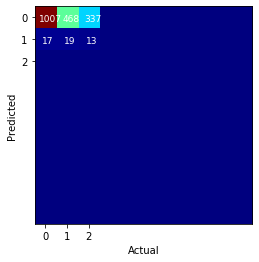

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(preds), numpy.asarray(labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [43]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '71d86b6d-1e11-464c-bb0a-1868d91872e0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '71d86b6d-1e11-464c-bb0a-1868d91872e0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 11 Aug 2020 11:23:54 GMT'},
  'RetryAttempts': 0}}

In [45]:
import sklearn
print(sklearn.metrics.classification_report(numpy.asarray(labels),numpy.asarray(preds)))

              precision    recall  f1-score   support

         0.0       0.56      0.98      0.71      1024
         1.0       0.39      0.04      0.07       487
         2.0       0.00      0.00      0.00       350

    accuracy                           0.55      1861
   macro avg       0.31      0.34      0.26      1861
weighted avg       0.41      0.55      0.41      1861



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
